In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('personal_transactions.csv')

https://www.kaggle.com/datasets/bukolafatunde/personal-finance?select=personal_transactions.csv

In [ ]:
data.head()

,Date,Description,Amount,Transaction Type,Category,Account Name
0,01/01/2018,Amazon,11.11,debit,Shopping,Platinum Card
1,01/02/2018,Mortgage Payment,1247.44,debit,Mortgage & Rent,Checking
2,01/02/2018,Thai Restaurant,24.22,debit,Restaurants,Silver Card
3,01/03/2018,Credit Card Payment,2298.09,credit,Credit Card Payment,Platinum Card
4,01/04/2018,Netflix,11.76,debit,Movies & DVDs,Platinum Card


In [ ]:
data.dtypes

,0
Date,object
Description,object
Amount,float64
Transaction Type,object
Category,object
Account Name,object


In [ ]:
from dateutil import parser
data['Date'] = data['Date'].apply(parser.parse)

In [ ]:
data.dtypes

,0
Date,datetime64[ns]
Description,object
Amount,float64
Transaction Type,object
Category,object
Account Name,object


In [ ]:
data.describe()

,Date,Amount
count,806,806.000000
mean,2018-11-12 00:00:00.000000256,273.391489
min,2018-01-01 00:00:00,1.750000
25%,2018-06-03 06:00:00,15.687500
50%,2018-11-11 00:00:00,37.480000
75%,2019-04-18 18:00:00,117.680000
max,2019-09-30 00:00:00,9200.000000
std,NaN,667.630374


In [ ]:
data.describe(include='object')

,Description,Transaction Type,Category,Account Name
count,806,806,806,806
unique,65,2,22,3
top,Credit Card Payment,debit,Credit Card Payment,Platinum Card
freq,143,688,143,366


In [ ]:
data['Category'].value_counts()

,count
Category,
Credit Card Payment,143
Groceries,105
Restaurants,81
Utilities,63
Shopping,60
Gas & Fuel,52
Paycheck,46
Home Improvement,36
Coffee Shops,31


In [ ]:
data['Month'] = data['Date'].dt.month
data['Year'] = data['Date'].dt.year
data['DayOfWeek'] = data['Date'].dt.weekday
data['saison'] = data['Date'].dt.quarter

In [ ]:
data.isnull().sum()

,0
Date,0
Description,0
Amount,0
Transaction Type,0
Category,0
Account Name,0
Month,0
Year,0
DayOfWeek,0
saison,0


In [ ]:
data[data.duplicated()]

,Date,Description,Amount,Transaction Type,Category,Account Name,Month,Year,DayOfWeek,saison


In [ ]:
data["Total Amount by Category by Month"] = data.groupby(["Category","Month"])["Amount"].transform("sum")

In [ ]:
data["Total Amount by Category by Year"] = data.groupby(["Category","Year"])["Amount"].transform("sum")

In [ ]:
data

,Date,Description,Amount,Transaction Type,Category,Account Name,Month,Year,DayOfWeek,saison,Total Amount by Category by Month,Total Amount by Category by Year
0,2018-01-01,Amazon,11.11,debit,Shopping,Platinum Card,1,2018,0,1,171.47,1418.50
1,2018-01-02,Mortgage Payment,1247.44,debit,Mortgage & Rent,Checking,1,2018,1,1,2347.44,14854.50
2,2018-01-02,Thai Restaurant,24.22,debit,Restaurants,Silver Card,1,2018,1,1,180.29,1634.10
3,2018-01-03,Credit Card Payment,2298.09,credit,Credit Card Payment,Platinum Card,1,2018,2,1,8248.01,33069.96
4,2018-01-04,Netflix,11.76,debit,Movies & DVDs,Platinum Card,1,2018,3,1,11.76,222.19
...,...,...,...,...,...,...,...,...,...,...,...,...
801,2019-09-27,Biweekly Paycheck,2250.00,credit,Paycheck,Checking,9,2019,4,3,8500.00,41750.00
802,2019-09-28,BP,33.46,debit,Gas & Fuel,Platinum Card,9,2019,5,3,184.07,619.26
803,2019-09-28,Sheetz,4.27,debit,Gas & Fuel,Platinum Card,9,2019,5,3,184.07,619.26
804,2019-09-30,Starbucks,1.75,debit,Coffee Shops,Platinum Card,9,2019,0,3,16.00,65.04


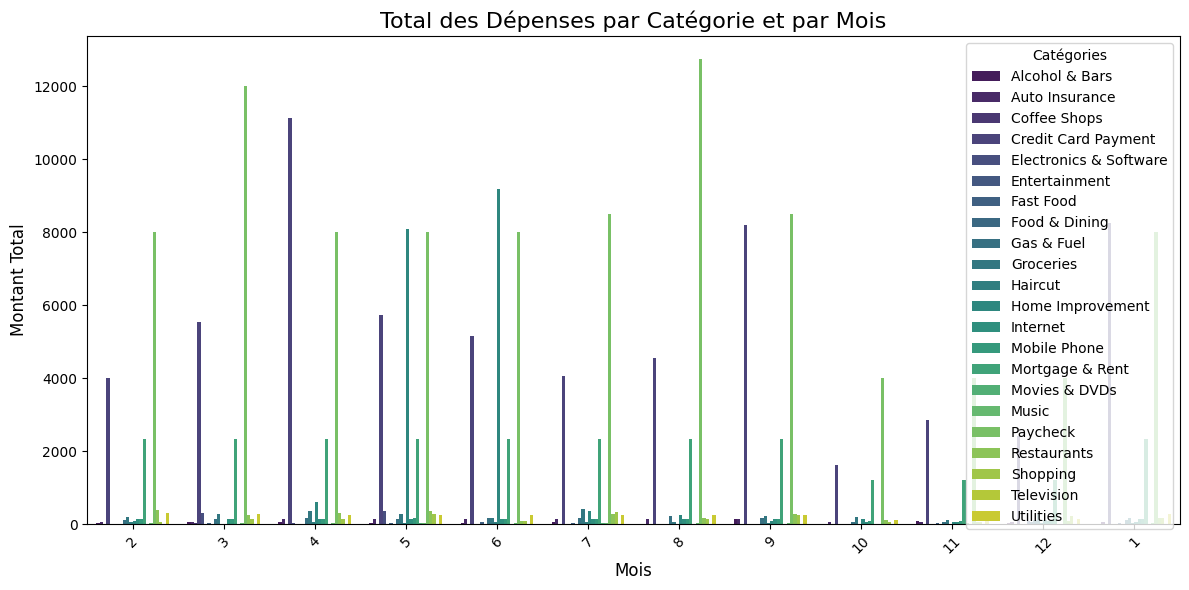

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df_debit = data[data["Transaction Type"] == "debit"]
df_debit = data.groupby(["Category", "Month"])["Amount"].sum().reset_index()

# Conversion de 'Month' en string pour l'affichage
df_debit['Month'] = df_debit['Month'].astype(str)

# Visualisation avec Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=df_debit, x="Month", y="Amount", hue="Category", palette="viridis")

# Ajout des détails au graphique
plt.title("Total des Dépenses par Catégorie et par Mois", fontsize=16)
plt.xlabel("Mois", fontsize=12)
plt.ylabel("Montant Total", fontsize=12)
plt.legend(title="Catégories", loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()

# Affichage du graphique
plt.show()

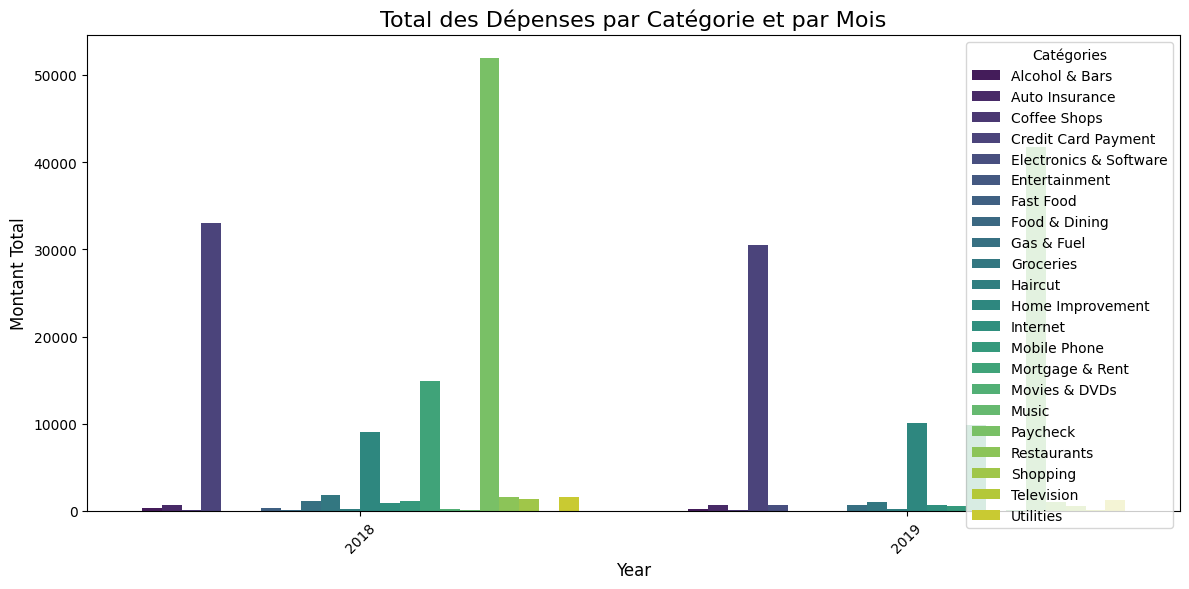

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

grouped = data.groupby(["Category", "Year"])["Amount"].sum().reset_index()

# Conversion de 'Month' en string pour l'affichage
grouped['Year'] = grouped['Year'].astype(str)

# Visualisation avec Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x="Year", y="Amount", hue="Category", palette="viridis")

# Ajout des détails au graphique
plt.title("Total des Dépenses par Catégorie et par Mois", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Montant Total", fontsize=12)
plt.legend(title="Catégories", loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()

# Affichage du graphique
plt.show()

<Axes: ylabel='Amount'>

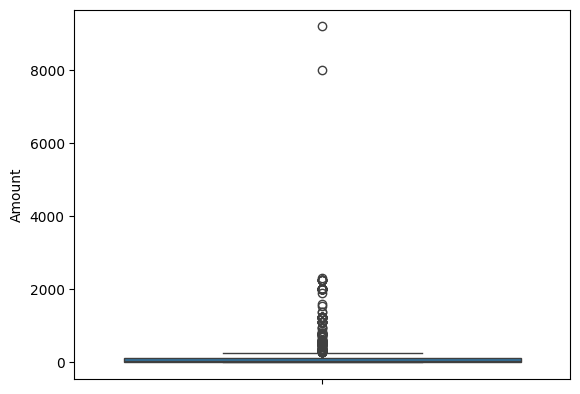

In [ ]:
sns.boxplot(data['Amount'])